Questo codice ha lo scopo di studiare la propagazione del segnale (q = Var(h)) in un LSTM. E' seguito da una seconda versione dove si randomizza sul valore iniziale degli hidden state, che qui è fissato, perchè si nota una dipendenza dall'inizializzazione in questo codice. Qui si studiano le average norms over time e si fitta un'esponenziale su avg norms over time, mentre in q_map2 si fitta un'esponenziale per ogni seed e poi si media sul tau di diversi seed. In qmap2 gli esponenziali sono anche centrati (tutte le norme vanno a zero perchè è stato tolto il loro punto fisso)

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit


In [ ]:
def define_pars(input_size, hidden_size, seed_, bias, vol=0.1, normalize=False):
    key = jax.random.PRNGKey(seed_)
    
    k1, k2, k3, k4, k5, k6, k7, k8 = jax.random.split(key, 8)

    if normalize:
        scale_f = vol * (1 / jnp.sqrt(hidden_size))
    else:
        scale_f = vol

    b_scale = bias #0.3
    # W_i: (input_size + hidden_size, hidden_size)
    W_i = jax.random.normal(k1, (input_size + hidden_size, hidden_size)) * scale_f
    # b_i: (hidden_size,)
    b_i = jax.random.normal(k5, (hidden_size,)) * b_scale
    #b_i = b_scale * jnp.ones((hidden_size,))
    
    # W_f: (input_size + hidden_size, hidden_size)
    W_f = jax.random.normal(k2, (input_size + hidden_size, hidden_size)) * scale_f
    # b_f: (hidden_size,)
    b_f = jax.random.normal(k6, (hidden_size,)) * b_scale
    #b_f = b_scale * jnp.ones((hidden_size,))
    
    # W_c: (input_size + hidden_size, hidden_size)
    W_c = jax.random.normal(k3, (input_size + hidden_size, hidden_size)) * scale_f
    # b_c: (hidden_size,)
    b_c = jax.random.normal(k7, (hidden_size,)) * b_scale
    #b_c = b_scale * jnp.ones((hidden_size,))
    
    # W_o: (input_size + hidden_size, hidden_size)
    W_o = jax.random.normal(k4, (input_size + hidden_size, hidden_size)) * scale_f
    # b_o: (hidden_size,)
    b_o = jax.random.normal(k8, (hidden_size,)) * b_scale
    #b_o = b_scale * jnp.ones((hidden_size,))

    return (W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o)

# Adjusted LSTMCell_test function
def LSTMCell_test(inputs, hidden_size, seed_, bias, vol=0.1, normalize=False):
    from jax.nn import sigmoid, tanh
    from jax.lax import scan

    # take always last dimension 
    num_ts, input_size = inputs.shape[-2], inputs.shape[-1]
    input_list = [input_size] 
    input_list += hidden_size[:-1]
    
    pars = {lr: define_pars(input_list[lr], hsz, seed_, bias, vol=vol, normalize=normalize) for lr, hsz in enumerate(hidden_size)}
    
    def f_scan(carry, x):
        h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o = carry
        
        # Concatenate current time step input with hidden state
        z = jnp.concatenate([x, h], axis=-1)

        i = sigmoid(jnp.dot(z, W_i) + b_i)
        f = sigmoid(jnp.dot(z, W_f) + b_f)
        o = sigmoid(jnp.dot(z, W_o) + b_o)
        c_hat = tanh(jnp.dot(z, W_c) + b_c)

        c = f * c + i * c_hat
        h = o * tanh(c)
        
        return (h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o), h
        
    # Initial hidden and cell states
    for lr, hsz in enumerate(hidden_size):
        h0 = 0.1*jnp.ones(hsz)  # fixed
        c0 = jnp.zeros(hsz)
        initial_state = (h0, c0) + pars[lr]
        final_state, outputs = scan(f_scan, initial_state, inputs)
        inputs = outputs  

    return final_state, outputs

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp

def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

# Parameters
key = jax.random.PRNGKey(7)
input_size = 3
hidden_size = [1000]
g_factors = np.linspace(0.3, 2, 20)
g_critico = 2 / jnp.sqrt(hidden_size[0])
num_steps = 2000
num_seeds = 5
bias_values = [0.01,0.015,0.02,0.025, 0.03,0.05]  
tau_results = np.zeros((len(bias_values), len(g_factors)))

def calculate_norm(h_t):
    return jnp.sqrt(jnp.mean(h_t ** 2))

# Iterazione su bias
for b_idx, b in enumerate(bias_values):
    # Iterazione su g_factors
    for g_idx, g_factor in enumerate(g_factors):
        g = g_factor * g_critico
        all_norms_over_time = []

        # Esecuzione su diversi seed
        for seed in range(num_seeds):
            inputs = jnp.zeros((num_steps, input_size))
            final_state, outputs = LSTMCell_test(inputs, hidden_size, seed, b, vol=g, normalize=False)
            norms_over_time = jnp.array([calculate_norm(h_t) for h_t in outputs])
            all_norms_over_time.append(norms_over_time)
        # Media delle norme su diversi seed
        avg_norms_over_time = np.mean(all_norms_over_time, axis=0)
        
        popt, _ = curve_fit(exp_decay, np.arange(num_steps), avg_norms_over_time)

        tau = popt[1]
        tau_results[b_idx, g_idx] = tau  # Memorizza tau nel risultato
        print(f"bias: {b:.2f}, g_factor: {g_factor:.2f}, avg_tau: {tau:.2f}")



bias: 0.01, g_factor: 0.30, avg_tau: 0.89
bias: 0.01, g_factor: 0.39, avg_tau: 1.06
bias: 0.01, g_factor: 0.48, avg_tau: 1.24
bias: 0.01, g_factor: 0.57, avg_tau: 1.45
bias: 0.01, g_factor: 0.66, avg_tau: 1.72


KeyboardInterrupt: 

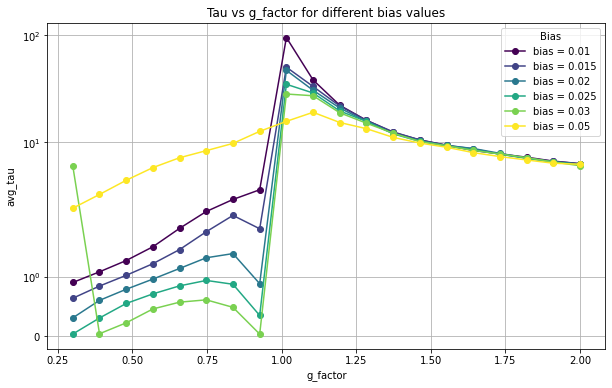

<Figure size 432x288 with 0 Axes>

In [ ]:

cmap = plt.get_cmap('viridis')  
colors = [cmap(i) for i in np.linspace(0, 1, len(bias_values))]

plt.figure(figsize=(10, 6))

# Itera sui risultati di tau
for b_idx, b in enumerate(bias_values):
    plt.plot(g_factors, tau_results[b_idx, :], label=f'bias = {b}', color=colors[b_idx], marker='o')

plt.title('Tau vs g_factor for different bias values')
plt.xlabel('g_factor')
plt.ylabel('avg_tau')
plt.legend(title='Bias')
plt.grid(True)
plt.yscale("symlog")
plt.show()

plt.savefig("tau_vs_g_factor.png", dpi=300)  

Codice dummy per vedere come evolvono le norme di h mediate tra i seed e capire quella valle a 1 se e instabilita numerica

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Exponential model function
def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C

# Parameters
key = jax.random.PRNGKey(7)
input_size = 3
hidden_size = [1000]
g_factors = [0.5,0.9,1,1.1,1.2,1.5,2,2.5]
g_critico = 2 / jnp.sqrt(hidden_size[0])
num_steps = 1000
num_seeds = 10
bias_values = [0] 
tau_results = np.zeros((len(bias_values), len(g_factors)))  
avg_norms_all = np.zeros((len(bias_values), len(g_factors), num_steps))  

def calculate_norm(h_t):
    return jnp.sqrt(jnp.mean(h_t ** 2))

# Iterazione su bias
for b_idx, b in enumerate(bias_values):
    # Iterazione su g_factors
    for g_idx, g_factor in enumerate(g_factors):
        g = g_factor * g_critico
        all_norms_over_time = []

        # Esecuzione su diversi seed
        for seed in range(num_seeds):
            inputs = jnp.zeros((num_steps, input_size))
            final_state, outputs = LSTMCell_test(inputs, hidden_size, seed, b, vol=g, normalize=False)
            norms_over_time = jnp.array([calculate_norm(h_t) for h_t in outputs])
            all_norms_over_time.append(norms_over_time)
        # Media delle norme su diversi seed
        avg_norms_over_time = np.mean(all_norms_over_time, axis=0)
        avg_norms_all[b_idx, g_idx, :] = avg_norms_over_time  # Salva i valori delle medie delle norme
        

        popt, _ = curve_fit(exp_decay, np.arange(num_steps), avg_norms_over_time)

        tau = popt[1]
        tau_results[b_idx, g_idx] = tau
        print(f"bias: {b:.2f}, g_factor: {g_factor:.2f}, avg_tau: {tau:.2f}")


bias: 0.00, g_factor: 0.50, avg_tau: 2.20
bias: 0.00, g_factor: 0.90, avg_tau: 9.72
bias: 0.00, g_factor: 1.00, avg_tau: 15.32
bias: 0.00, g_factor: 1.10, avg_tau: 40.61
bias: 0.00, g_factor: 1.20, avg_tau: 20.60
bias: 0.00, g_factor: 1.50, avg_tau: 10.04
bias: 0.00, g_factor: 2.00, avg_tau: 5.95
bias: 0.00, g_factor: 2.50, avg_tau: 4.85


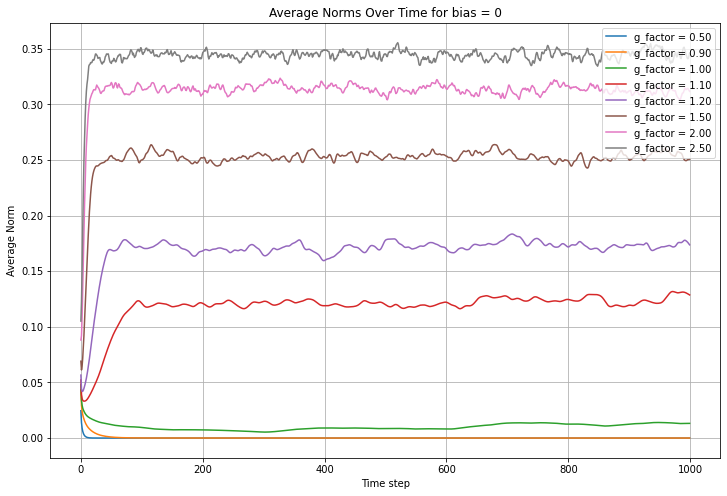

In [ ]:
# Per plottare gli avg_norms_all
for b_idx, b in enumerate(bias_values):
    plt.figure(figsize=(12, 8))
    for g_idx, g_factor in enumerate(g_factors):
        plt.plot(np.arange(num_steps), avg_norms_all[b_idx, g_idx, :], label=f'g_factor = {g_factor:.2f}')
    plt.title(f'Average Norms Over Time for bias = {b}')
    plt.xlabel('Time step')
    plt.ylabel('Average Norm')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()